In [150]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
palette = plt.rcParams['axes.prop_cycle'].by_key()['color']
import seaborn as sns
import robust_loss_pytorch.general
import numpy.random as npr
from robust_loss_pytorch import distribution
import random
import torch.nn as nn
import pandas as pd
# Construct some regression data with some extreme outliers.
np.random.seed(1234)
torch.manual_seed(1234)

class RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(1, 1)
    def forward(self, x): 
        return self.linear(x[:,None])[:,0]
    
class Poly2RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(Poly2RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(2, 1)
    def forward(self, x): 
        x = torch.cat([(x**2).view(-1,1), x.view(-1,1)], axis=1)
        return self.linear(x)[:,0]
    
class Poly2RegressionModel_with_class(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(Poly2RegressionModel_with_class, self).__init__() 
        self.linear = torch.nn.Linear(3, 1)
    def forward(self, x, c): 
        x = torch.cat([(x**2).view(-1,1), x.view(-1,1)], axis=1)
        x = torch.cat([x, c.view(-1,1)], axis=1)
        return self.linear(x)[:,0]

def plot_regression(regression, u=None, c=None):
    # A helper function for plotting a regression module.
    x_plot = np.linspace(min(x), max(x), 500)
    if c is None:
        y_plot = regression(torch.Tensor(x_plot)).detach().numpy()
    else:
        y_plot = regression(torch.Tensor(x_plot), c).detach().numpy()
#     y_plot_true = x_plot * scale_true + shift_true
    
    plt.figure(0, figsize=(4,4))
    if u is not None:
        sns.scatterplot(x, y, hue=U)
    else:
        sns.scatterplot(x, y)
#     plt.plot(x_plot, y_plot_true, color='k')
    plt.plot(x_plot, y_plot, color='navy', label='regressor')
    plt.legend()

# Heteroskedastic data

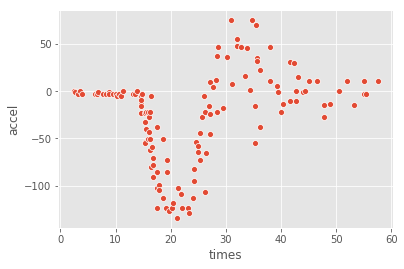

In [151]:
X = pd.read_csv('dataset/mcycle.csv')
sns.scatterplot(X['times'], X['accel'])
N = len(X)
x_motor = X['times']
y_motor = X['accel']

## Linear regression with regular MSE

0   : loss=141186.000000
500 : loss=129657.500000
1000: loss=125096.804688
1500: loss=121207.039062
MSE: 2357.833740


OrderedDict([('weight', Parameter containing:
              tensor([[0.0307]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([-19.1307], requires_grad=True))])

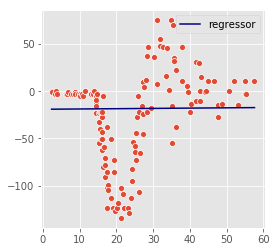

In [152]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
optimizer = torch.optim.Adam(list(params), lr = 0.01) 
x = torch.Tensor(x_motor)
y = torch.Tensor(y_motor)
for epoch in range(2000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.Tensor([2.]), scale=torch.Tensor([0.1])))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        print('{:<4}: loss={:03f}'.format(epoch, loss.data)) 
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))
regression.linear._parameters

## Linear regression with Adaptive Roust loss

0   : loss=1337.180908  alpha=1.997990  scale=1.006333
500 : loss=24.178947  alpha=1.214970  scale=2.500109
1000: loss=8.645836  alpha=0.528639  scale=2.540752
1500: loss=7.222684  alpha=0.328529  scale=2.559169
2000: loss=6.707303  alpha=0.226753  scale=2.575078
2500: loss=6.445862  alpha=0.164958  scale=2.591081
3000: loss=6.290352  alpha=0.123859  scale=2.608366
3500: loss=6.188519  alpha=0.094960  scale=2.627841
4000: loss=6.117181  alpha=0.073871  scale=2.650407
4500: loss=6.064461  alpha=0.058079  scale=2.677076
MSE: 2842.306641


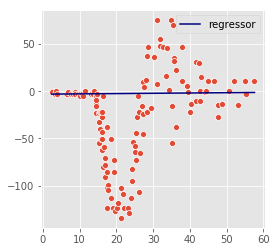

In [153]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu', alpha_init=1.998)
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 
x = torch.Tensor(x_motor)
y = torch.Tensor(y_motor)
hetero_alpha = []
hetero_scale = []
for epoch in range(5000): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 500) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 
    hetero_alpha.append(adaptive.alpha()[0,0].data.numpy())
    hetero_scale.append(adaptive.scale()[0,0].data.numpy())

# It fits!
plot_regression(regression)
regression.linear._parameters
y_hat = regression(x) 
mse = ((y_hat-y)**2).mean().detach().numpy()
print('MSE: {:02f}'.format(mse))

Text(0, 0.5, 'log alpha')

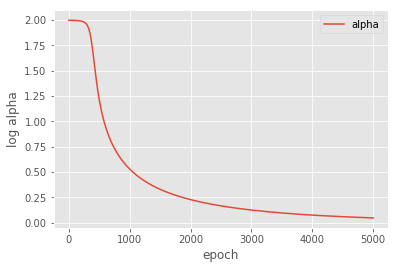

In [154]:
sns.lineplot(np.arange(len(hetero_alpha)), np.array(hetero_alpha), label="alpha")
plt.xlabel('epoch')
plt.ylabel('log alpha')

Text(0, 0.5, 'log scale parameter')

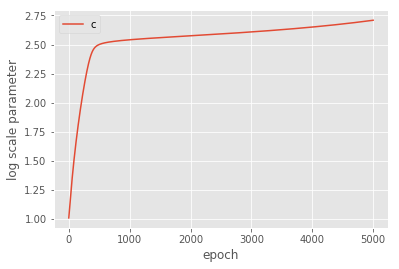

In [155]:
sns.lineplot(np.arange(len(hetero_alpha)), np.array(hetero_scale), label="c")
plt.xlabel('epoch')
plt.ylabel('log scale parameter')

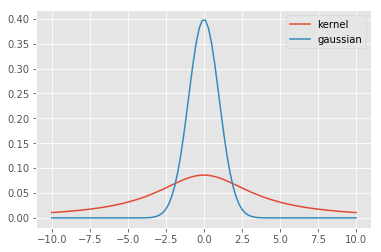

In [156]:
dist = distribution.Distribution()
alpha=hetero_alpha[-1]
scale=hetero_scale[-1]
x_range = 10
y = dist.nllfun(torch.Tensor(np.linspace(-x_range, x_range, 100)), float(alpha), float(scale)).data.numpy()
sns.lineplot(np.linspace(-x_range, x_range, 100), np.exp(-y), label='kernel')
y = dist.nllfun(torch.Tensor(np.linspace(-x_range, x_range, 100)), float(2), float(1)).data.numpy()
sns.lineplot(np.linspace(-x_range, x_range, 100), np.exp(-y), label='gaussian')

# Optimize Alpha for each data

## fit N alpha and N variance-term

0   : loss=2828.951660
1000: loss=9.069995
2000: loss=4.337555
3000: loss=2.605421
4000: loss=1.666652
5000: loss=1.072483
6000: loss=0.671061
7000: loss=0.400320
8000: loss=0.223216
9000: loss=0.118354
10000: loss=0.060469
11000: loss=0.031130
12000: loss=0.016882
13000: loss=0.009584
14000: loss=0.005553
15000: loss=0.003236
16000: loss=0.001897
17000: loss=0.001135
18000: loss=0.000691
19000: loss=0.000421


OrderedDict([('weight', Parameter containing:
              tensor([[-3.7571]], requires_grad=True)),
             ('bias', Parameter containing:
              tensor([-5.3031], requires_grad=True))])

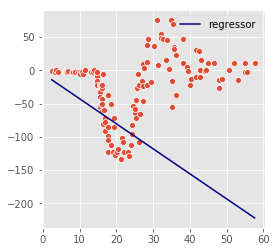

In [169]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
alpha_dense = nn.Parameter(torch.Tensor([1]*len(x_motor)))
scale_dense = nn.Parameter(torch.Tensor([1]*len(x_motor)))
optimizer = torch.optim.Adam([scale_dense, alpha_dense]+list(params), lr = 0.01) 
x = torch.Tensor(x_motor)
y = torch.Tensor(y_motor)
for epoch in range(20000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.exp(alpha_dense), scale=torch.exp(scale_dense)))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  
plot_regression(regression)
regression.linear._parameters

Text(0, 0.5, 'accel')

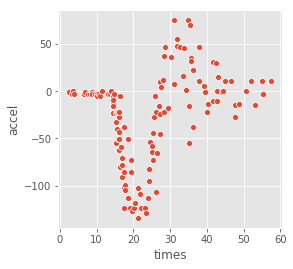

In [170]:
plt.figure(0, figsize=(4,4))
sns.scatterplot(x.data.numpy(), y.data.numpy())
alpha_hat_dense = torch.exp(alpha_dense).data.numpy()
scale_hat_dense = torch.exp(scale_dense).data.numpy()
plt.xlabel('times')
plt.ylabel('accel')

Text(0.5, 0, 'times')

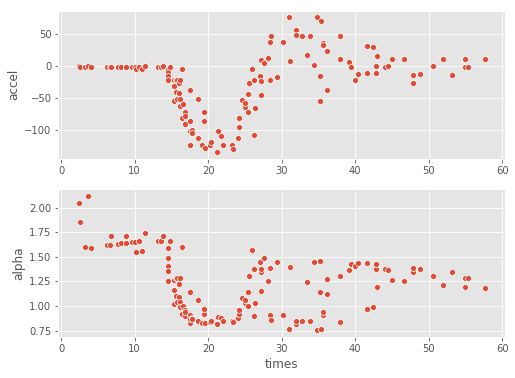

In [171]:
fig, ax = plt.subplots(2, 1, figsize=(8,6))
sns.scatterplot(x.data.numpy(), y.data.numpy(), ax=ax[0])
ax[0].set_ylabel('accel')
sns.scatterplot(x.data.numpy(), alpha_hat_dense, ax=ax[1])
ax[1].set_ylabel('alpha')
plt.xlabel('times')

Text(0.5, 0, 'times')

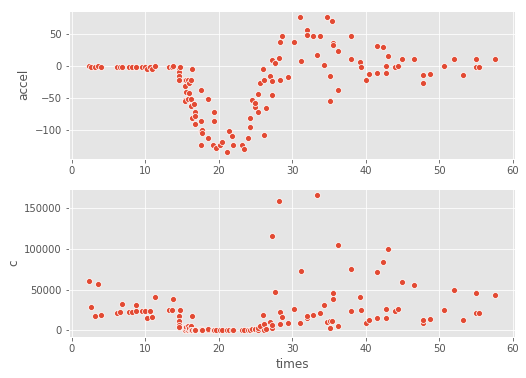

In [172]:
fig, ax = plt.subplots(2, 1, figsize=(8,6))
sns.scatterplot(x.data.numpy(), y.data.numpy(), ax=ax[0])
ax[0].set_ylabel('accel')
sns.scatterplot(x.data.numpy(), scale_hat_dense, ax=ax[1])
ax[1].set_ylabel('c')
plt.xlabel('times')

## fit N alpha and 1 variance-term

0   : loss=2838.037109
1000: loss=9.640691
2000: loss=4.943889
3000: loss=3.136448
4000: loss=2.074041
5000: loss=1.338677
6000: loss=0.815422
7000: loss=0.464140
8000: loss=0.249999
9000: loss=0.131210
10000: loss=0.069208
11000: loss=0.037376
12000: loss=0.020763
13000: loss=0.011824
14000: loss=0.006865
15000: loss=0.004042
16000: loss=0.002403
17000: loss=0.001438
18000: loss=0.000865
19000: loss=0.000521


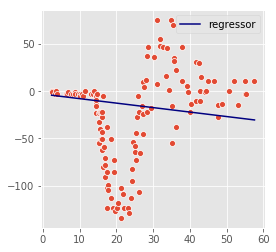

In [173]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
alpha_dense = nn.Parameter(torch.Tensor([1]*len(x_motor)))
scale_dense = nn.Parameter(torch.Tensor([1]))
optimizer = torch.optim.Adam([scale_dense, alpha_dense]+list(params), lr = 0.01) 
x = torch.Tensor(x_motor)
y = torch.Tensor(y_motor)
for epoch in range(20000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.exp(alpha_dense), scale=torch.exp(scale_dense)))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  
plot_regression(regression)
regression.linear._parameters
alpha_hat_dense = torch.exp(alpha_dense).data.numpy()
scale_hat_dense = torch.exp(scale_dense).data.numpy()

Text(0.5, 0, 'times')

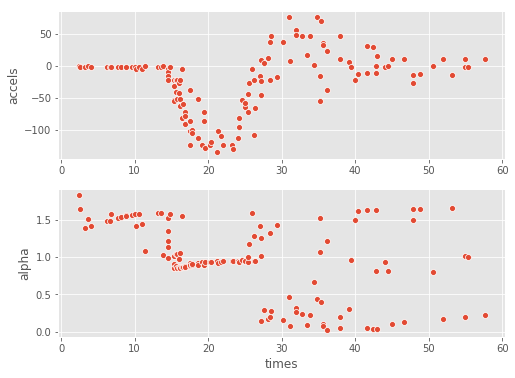

In [174]:
fig, ax = plt.subplots(2, 1, figsize=(8,6))
sns.scatterplot(x.data.numpy(), y.data.numpy(), ax=ax[0])
ax[0].set_ylabel('accels')
sns.scatterplot(x.data.numpy(), alpha_hat_dense, ax=ax[1])
ax[1].set_ylabel('alpha')
plt.xlabel('times')

Text(0.5, 0, 'times')

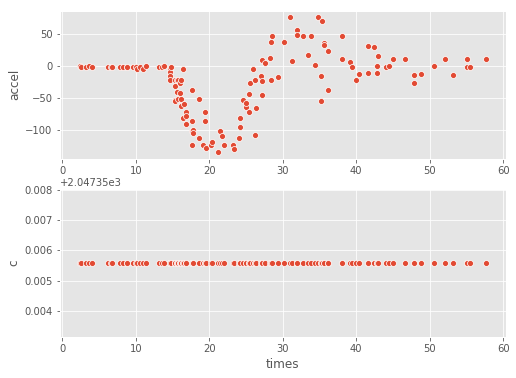

In [175]:
fig, ax = plt.subplots(2, 1, figsize=(8,6))
sns.scatterplot(x.data.numpy(), y.data.numpy(), ax=ax[0])
ax[0].set_ylabel('accel')
sns.scatterplot(x.data.numpy(), np.repeat(scale_hat_dense, len(x)), ax=ax[1])
ax[1].set_ylabel('c')
plt.xlabel('times')

Text(0.5, 0, 'times')

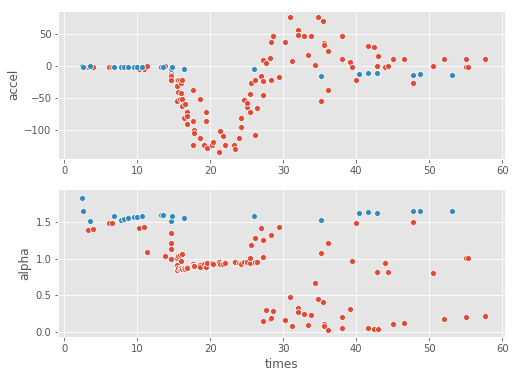

In [176]:
fig, ax = plt.subplots(2, 1, figsize=(8,6))
sns.scatterplot(x.data.numpy(), y.data.numpy(), ax=ax[0])
sns.scatterplot(x.data.numpy()[alpha_hat_dense>1.5], y.data.numpy()[alpha_hat_dense>1.5], ax=ax[0])
ax[0].set_ylabel('accel')
sns.scatterplot(x.data.numpy(), alpha_hat_dense, ax=ax[1])
sns.scatterplot(x.data.numpy()[alpha_hat_dense>1.5], alpha_hat_dense[alpha_hat_dense>1.5], ax=ax[1])
ax[1].set_ylabel('alpha')
plt.xlabel('times')

## fit 1 alpha and N variance-term

0   : loss=1830.617065
1000: loss=7.477831
2000: loss=3.573492
3000: loss=2.073933
4000: loss=1.245667
5000: loss=0.730703
6000: loss=0.403384
7000: loss=0.208532
8000: loss=0.102317
9000: loss=0.052255
10000: loss=0.028481
11000: loss=0.016166
12000: loss=0.009496
13000: loss=0.005765
14000: loss=0.003574
15000: loss=0.002231
16000: loss=0.001392
17000: loss=0.000866
18000: loss=0.000537
19000: loss=0.000331


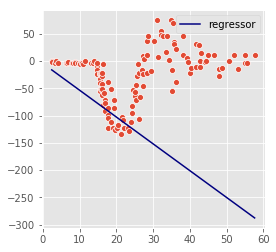

In [177]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
alpha_dense = nn.Parameter(torch.Tensor([1]))
scale_dense = nn.Parameter(torch.Tensor([1]*len(x_motor)))
optimizer = torch.optim.Adam([scale_dense, alpha_dense]+list(params), lr = 0.01) 
x = torch.Tensor(x_motor)
y = torch.Tensor(y_motor)
for epoch in range(20000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.exp(alpha_dense), scale=torch.exp(scale_dense)))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 1000) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}'.format(epoch, loss.data))  
plot_regression(regression)
regression.linear._parameters
alpha_hat_dense = torch.exp(alpha_dense).data.numpy()
scale_hat_dense = torch.exp(scale_dense).data.numpy()

Text(0.5, 0, 'times')

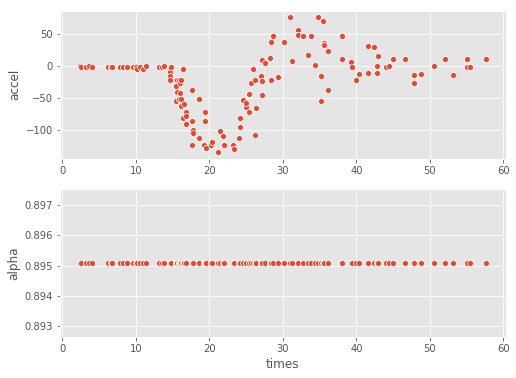

In [178]:
fig, ax = plt.subplots(2, 1, figsize=(8,6))
sns.scatterplot(x.data.numpy(), y.data.numpy(), ax=ax[0])
ax[0].set_ylabel('accel')
sns.scatterplot(x.data.numpy(), np.repeat(alpha_hat_dense, len(x)), ax=ax[1])
ax[1].set_ylabel('alpha')
plt.xlabel('times')

Text(0.5, 0, 'times')

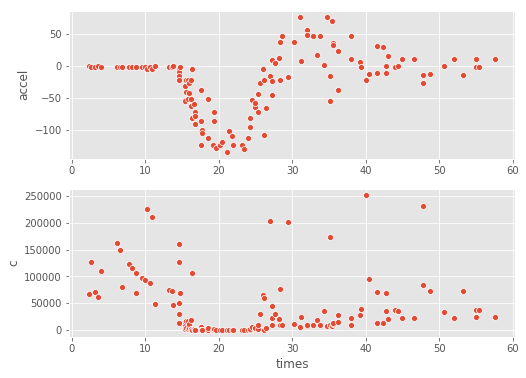

In [179]:
fig, ax = plt.subplots(2, 1, figsize=(8,6))
sns.scatterplot(x.data.numpy(), y.data.numpy(), ax=ax[0])
ax[0].set_ylabel('accel')
sns.scatterplot(x.data.numpy(), scale_hat_dense, ax=ax[1])
ax[1].set_ylabel('c')
plt.xlabel('times')

Text(0.5, 0, 'times')

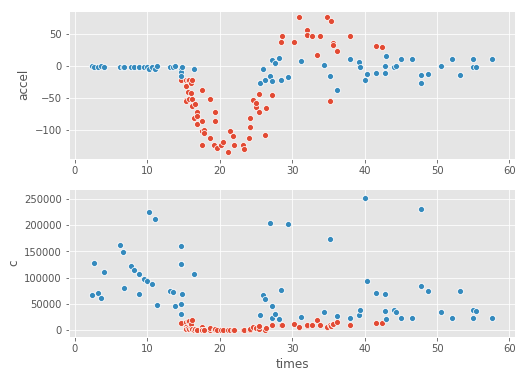

In [184]:
fig, ax = plt.subplots(2, 1, figsize=(8,6))
sns.scatterplot(x.data.numpy(), y.data.numpy(), ax=ax[0])
sns.scatterplot(x.data.numpy()[scale_hat_dense>20000], y.data.numpy()[scale_hat_dense>20000], ax=ax[0])

ax[0].set_ylabel('accel')
sns.scatterplot(x.data.numpy(), scale_hat_dense, ax=ax[1])
sns.scatterplot(x.data.numpy()[scale_hat_dense>20000], scale_hat_dense[scale_hat_dense>20000], ax=ax[1])
ax[1].set_ylabel('c')
plt.xlabel('times')